# Solution

Here you will find the solution for the challenge E.

In [1]:
from fenics import Point, CompiledSubDomain, MeshFunction, XDMFFile, SubDomain
from mshr import Rectangle, generate_mesh

inlet_id = 1
vacuum_id = 2
outlet_id = 3
axis_id = 4

id_fluid = 5
id_pipe_walls = 6


def create_mesh(length, inner_radius, pipe_thickness, refinement=300):
    """Creates a mesh for the challenge E and writes the XDMF files
    to the challenge_E folder.

    Args:
        length (float): length of the pipe (m)
        inner_radius (float): inner radius of the pipe (m)
        pipe_thickness (float): pipe thickness (m)
        refinement (int, optional): refinement index, the higher the index
            the finer the mesh. Defaults to 300.
    """
    p1 = Point(0, 0)
    p2 = Point(inner_radius, length)
    fluid_rectangle = Rectangle(p1, p2)

    p1 = Point(inner_radius, 0)
    p2 = Point(inner_radius + pipe_thickness, length)
    pipe_rectangle = Rectangle(p1, p2)

    domain = fluid_rectangle + pipe_rectangle

    domain.set_subdomain(1, fluid_rectangle)
    domain.set_subdomain(2, pipe_rectangle)
    mesh = generate_mesh(domain, refinement)

    # marking physical groups (volumes and surfaces)
    volume_markers = MeshFunction("size_t", mesh, mesh.topology().dim())
    volume_markers.set_all(1)

    tol = 1e-14

    id_fluid = 5
    id_pipe_walls = 6

    class Fluid(SubDomain):
        def inside(self, x, on_boundary):
            return x[0] <= inner_radius + tol

    class Pipe(SubDomain):
        def inside(self, x, on_boundary):
            return x[0] >= inner_radius - tol

    fluid = Fluid()
    pipe = Pipe()
    # marking volumes
    fluid.mark(volume_markers, id_fluid)
    pipe.mark(volume_markers, id_pipe_walls)

    tol = 1e-14

    inlet_surface = CompiledSubDomain(
        "on_boundary && near(x[1], 0, tol) && x[0] < inner_radius + tol",
        tol=tol,
        inner_radius=inner_radius,
    )
    outlet_surface = CompiledSubDomain(
        "on_boundary && near(x[1], outlet_x, tol) && x[0] < inner_radius + tol",
        tol=tol,
        inner_radius=inner_radius,
        outlet_x=length,
    )
    bottom_surface = CompiledSubDomain("on_boundary && near(x[0], 0, tol)", tol=tol)
    top_surface = CompiledSubDomain(
        "on_boundary && near(x[0], top_y, tol)",
        tol=tol,
        top_y=inner_radius + pipe_thickness,
    )

    surface_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    surface_markers.set_all(0)

    inlet_surface.mark(surface_markers, inlet_id)
    outlet_surface.mark(surface_markers, outlet_id)
    top_surface.mark(surface_markers, vacuum_id)
    bottom_surface.mark(surface_markers, axis_id)

    output_file = XDMFFile("challenge_E/surface_markers.xdmf")
    output_file.write(surface_markers)

    output_file2 = XDMFFile("challenge_E/volume_markers.xdmf")
    output_file2.write(volume_markers)

In [2]:
import festim as F


class AverageSurfaceCylindrical(F.AverageSurface):
    """
    Computes the average value of a field on a given surface
    int(f ds) / int (1 * ds)
    ds is the surface measure in cylindrical coordinates.
    ds = r dr dtheta

    Args:
        field (str, int):  the field ("solute", 0, 1, "T", "retention")
        surface (int): the surface id

    Notes:
        Units are in H/m3 for hydrogen concentration and K for temperature
    """

    def __init__(self, field, surface) -> None:
        super().__init__(field=field, surface=surface)
        self.r = None

    @property
    def allowed_meshes(self):
        return ["cylindrical"]

    def compute(self):

        if self.r is None:
            mesh = (
                self.function.function_space().mesh()
            )  # get the mesh from the function
            rthetaz = f.SpatialCoordinate(mesh)  # get the coordinates from the mesh
            self.r = rthetaz[0]  # only care about r here

        # dS_z = r dr dtheta , assuming axisymmetry dS_z = theta r dr
        # dS_r = r dz dtheta , assuming axisymmetry dS_r = theta r dz
        # in both cases the expression with self.dx is the same

        avg_surf = f.assemble(
            self.function * self.r * self.ds(self.surface)
        ) / f.assemble(1 * self.r * self.ds(self.surface))

        return avg_surf

In [3]:
temperature = 800  # K
length = 0.3  # m
inner_radius = 1e-2  # m
pipe_thickness = 4e-3  # m
velocity = 40e-2  # m/s

create_mesh(length, inner_radius, pipe_thickness)

In [4]:
import h_transport_materials as htm

D_pbli = (
    htm.diffusivities.filter(material="lipb")
    .filter(isotope="h")
    .filter(author="reiter")
)[0]
S_pbli = (
    htm.solubilities.filter(material="lipb").filter(isotope="h").filter(author="aiello")
)[0]

D_eurofer = htm.diffusivities.filter(material="eurofer_97").filter(author="chen")[0]
S_eurofer = htm.solubilities.filter(material="eurofer_97").filter(author="chen")[0]

In [5]:
my_model = F.Simulation()

my_model.mesh = F.MeshFromXDMF(
    volume_file="challenge_E/volume_markers.xdmf",
    boundary_file="challenge_E/surface_markers.xdmf",
    type="cylindrical",
)

# materials
eurofer = F.Material(
    id=id_pipe_walls,
    D_0=D_eurofer.pre_exp.magnitude,
    E_D=D_eurofer.act_energy.magnitude,
    S_0=S_eurofer.pre_exp.magnitude,
    E_S=S_eurofer.act_energy.magnitude,
)
lipb = F.Material(
    id=id_fluid,
    D_0=D_pbli.pre_exp.magnitude,
    E_D=D_pbli.act_energy.magnitude,
    S_0=S_pbli.pre_exp.magnitude,
    E_S=S_pbli.act_energy.magnitude,
)
my_model.materials = F.Materials([eurofer, lipb])

my_model.T = temperature

my_model.boundary_conditions = [
    F.DirichletBC(field="solute", surfaces=vacuum_id, value=0),
    F.DirichletBC(field="solute", surfaces=inlet_id, value=1e18),
]

c_in = AverageSurfaceCylindrical("solute", inlet_id)
c_out = AverageSurfaceCylindrical("solute", outlet_id)

derived_quantities = F.DerivedQuantities([c_in, c_out], show_units=True)

my_model.exports = F.Exports(
    [F.XDMFExport("solute", folder="challenge_E/", mode=1), derived_quantities]
)

my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=False,
    chemical_pot=True,
)
my_model.initialise()

Succesfully load mesh with 24228 cells
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


In [6]:
import fenics as f

mesh_sub = f.SubMesh(my_model.mesh.mesh, my_model.mesh.volume_markers, id_fluid)

functionspace = f.VectorFunctionSpace(mesh_sub, "CG", 1)

velocity_expr = f.Expression(
    ("0", "v*(x[0] - inner_radius)*(x[0] + inner_radius)"),
    v=velocity,
    inner_radius=inner_radius,
    degree=2,
)

velocity_function = f.interpolate(velocity_expr, functionspace)

V = f.VectorFunctionSpace(my_model.mesh.mesh, "CG", 1)
u = f.Function(V)
v = f.TestFunction(V)

form = f.inner(u, v) * my_model.mesh.dx
form += f.inner(velocity_function, v) * my_model.mesh.dx(id_fluid)
f.solve(form == 0, u, bcs=[])

velocity_function = u

XDMFFile("challenge_E/velocity_field.xdmf").write(velocity_function)
hydrogen_concentration = my_model.h_transport_problem.mobile.mobile_concentration()
test_function_mobile = my_model.h_transport_problem.mobile.test_function
advection_term = f.inner(
    f.dot(f.grad(hydrogen_concentration), velocity_function), test_function_mobile
) * my_model.mesh.dx(id_fluid)
my_model.h_transport_problem.F += advection_term

my_model.run()

Solving steady state problem...
Solved problem in 0.70 s


In [7]:
c_out = c_out.data[0]
c_in = c_in.data[0]

In [8]:
efficiency = 1 - c_out / c_in

print(f"Efficiency: {efficiency:.2%}")

Efficiency: 62.11%


You can also plot visualise the concentration field in Paraview to better see the discontinuities.

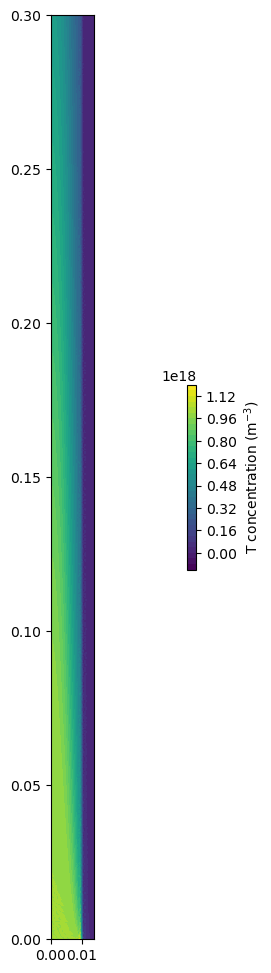

In [20]:
mobile_concentration = my_model.h_transport_problem.mobile.mobile_concentration()
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 12))
CS = f.plot(mobile_concentration)
plt.colorbar(CS, shrink=0.2, label="T concentration (m$^{-3}$)")
plt.show()